In [3]:
import glob
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpl_image
%matplotlib inline  
import cv2
import errno

In [4]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
def log_progress(sequence, title='', every=1, size=None, end_msg='', removeAtTheEnd=False):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    if isinstance(sequence, dict):
                        val = ''
                    else:
                        val=sequence[index-1]
                            
                    label.value = u'{title} : {value} ({index} / {size})'.format(
                        title=title,
                        value=val,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = end_msg
        if removeAtTheEnd:
            box.close()
    

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
pathBasic='/home/jguerry/workspace/datasets/ONERA.ROOM'
allFolders=sorted(glob.glob(pathBasic+"/RGBD/*"))

In [6]:
pathFolder ='2017-04-26-14-06-49' #static, with light change
    

## Computing mean

In [7]:
folder='/home/jguerry/workspace/datasets/ONERA.ROOM/RGBD/'+pathFolder
print folder
print 'Globing...'
imgs_rgb=sorted(glob.glob(folder+"/image/*"))
print 'Globbed'

means=np.zeros((len(imgs_rgb),1))
filenames=[]

print 'Evaluating set...'
for i in log_progress(range(len(imgs_rgb)),title='Images', end_msg='Finished !'): 
    img=cv2.imread(imgs_rgb[i])
    mean=img.mean()
    
    
    fileName_rgb = os.path.split(os.path.split(imgs_rgb[i])[-1])[-1]
    newfileName_rgb = pathFolder+'_'+fileName_rgb[:-4]
    
    means[i]=mean
    filenames.append(newfileName_rgb)
print 'Finished.'

/home/jguerry/workspace/datasets/ONERA.ROOM/RGBD/2017-04-26-14-06-49
Globing...
Globbed
Evaluating set...


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Finished.


## Plotting evolution of mean luminosity

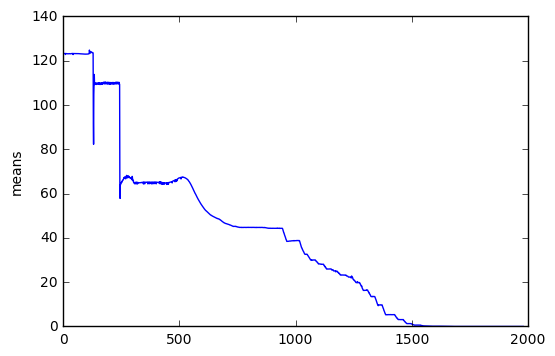

In [8]:
plt.plot(means)
plt.ylabel('means')
plt.show()

## Selecting images

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


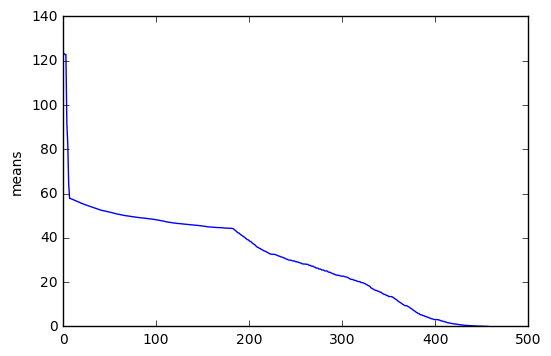

Selected points : 458


In [9]:
resolution = 10000.

mean_max = np.max(means)
mean_min = np.min(means)

delta=mean_max-mean_min
step=delta/resolution
steps = np.arange(mean_max,mean_min,-step)

selected_x=[]
last_x=0
last_intensity=1000
for intensity in log_progress(steps,title='Intensity steps', end_msg='Finished !'): 
    last_x=0
#     last_intensity=1000
    for x in range(last_x,len(means)):
        last_x=x
        if means[x]<intensity and intensity<last_intensity:
            selected_x.append(x)
            last_intensity=means[x]
            break
            
            
plt.plot(means[selected_x])
# plt.plot(selected_x)
plt.ylabel('means')
plt.show()

print 'Selected points :',len(selected_x)

In [23]:
ratio=0.01

AttributeError: 'str' object has no attribute 'is_bbox'

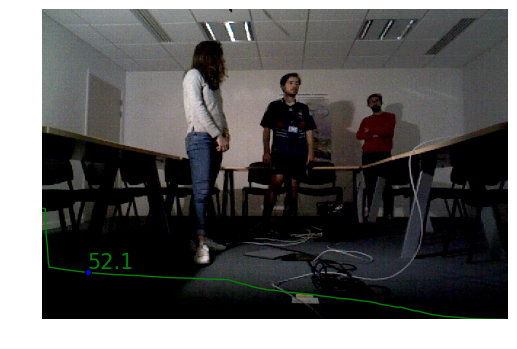

In [24]:
ratio+=0.09
indice=int(ratio*len(selected_x))
path_img = imgs_rgb[selected_x[indice]]
mean_img = means[selected_x[indice],0]
im = mpl_image.imread(path_img)


nb_pts=len(selected_x)
width_of_im = 640/640*nb_pts
height_of_im = 480./640*nb_pts



fig, ax = plt.subplots()
ax.imshow(im, aspect='auto', extent=(0, width_of_im, 0,height_of_im ), zorder=-1)
plt.axis('off')
# ax.yaxis.tick_left()
# ax.tick_params(axis='y', colors='black', labelsize=15)
# ax.tick_params(axis='x', colors='black', labelsize=15)
# ax.grid(b=False, which='major', color='#D3D3D3', linestyle='-')

if ratio<0.5:
    verticalalignment='bottom'
    horizontalalignment='left'
else:
    verticalalignment='bottom'
    horizontalalignment='right'
ax.text(indice, mean_img,'{:.1f}'.format(mean_img), fontsize=15,color='green',verticalalignment=verticalalignment, horizontalalignment=horizontalalignment)
plt.plot(means[selected_x],alpha=1.0,color='green')
ax.scatter(indice,mean_img, alpha=1.0,zorder=+4)

ax = plt.gca();
ax.set_xlim(0.0, width_of_im);
ax.set_ylim(0, height_of_im);
plt.savefig( '/tmp/match.png',bbox_inches='none', transparent="True",pad_inches=0)


plt.show()

## Making the set

In [ ]:
f = open('/home/jguerry/workspace/datasets/ONERA.ROOM/data_pv/sets/static_monotonous.txt', 'w')
for i in range(len(imgs_rgb)):  
    fileName_rgb='test'
    f.write(fileName_rgb+'\n')
print 'Finished.'
f.close()

In [ ]:
j=0

In [ ]:
j+=1
img=cv2.imread(imgs_rgb[selected_x[j]])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(img.mean())